# Project 2 (Bipartite Graphs) - DATA 620 
## Shri Tripathi


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from networkx.algorithms import bipartite as bi

# Instructions:
- Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
- Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
- What can you infer about each of the distinct groups?

## Overview

For this project, I used a dataset from the "Large-scale Multi-layer Academic Networks (LMANStat)" package. The dataset includes two Excel files containing detailed author and paper information (such as unique IDs and related attributes) and eight CSV files that represent the edge lists. My analysis focused specifically on the author-to-paper edge list.

### Data

In [69]:
df = pd.read_csv("https://raw.githubusercontent.com/Gaotianchen97/LMANStat/main/Edgelist_author_paper_network.csv")

In [70]:
df

,Target,Source,Year
0,Paper_1,Author_50203,2000
1,Paper_2,Author_33399,2000
2,Paper_2,Author_29791,2000
3,Paper_3,Author_24663,2000
4,Paper_4,Author_43104,2000
...,...,...,...
217769,Paper_97434,Author_53211,2012
217770,Paper_97435,Author_39993,2010
217771,Paper_97435,Author_10595,2010
217772,Paper_97435,Author_70265,2010


To build a bipartite graph, the first step is to form two sets: one for the papers and another for the authors.

In [71]:
paper = pd.DataFrame(df.Target.unique(),columns = ['Paper'])
author = pd.DataFrame(df.Source.unique(),columns = ['Author'])

In [72]:
paper_list = paper['Paper'].to_list()

In [73]:
author_list = author['Author'].to_list()

Once the sets are established, I construct the bipartite graph by using the `add_nodes_from()` function from the NetworkX library.

In [74]:
G = nx.Graph() #create an empty graph
G.add_nodes_from(author_list, bipartite = "authors")
G.add_nodes_from(paper_list, bipartite = "papers")

Inspecting the nodes with the `data=True` argument confirms that the partition information is properly stored.

In [75]:
edges = df[['Target','Source']]

In [76]:
edges_tuple = [tuple(i) for i in edges.values]

In [77]:
G.add_edges_from(edges_tuple)


### Graphing the Data

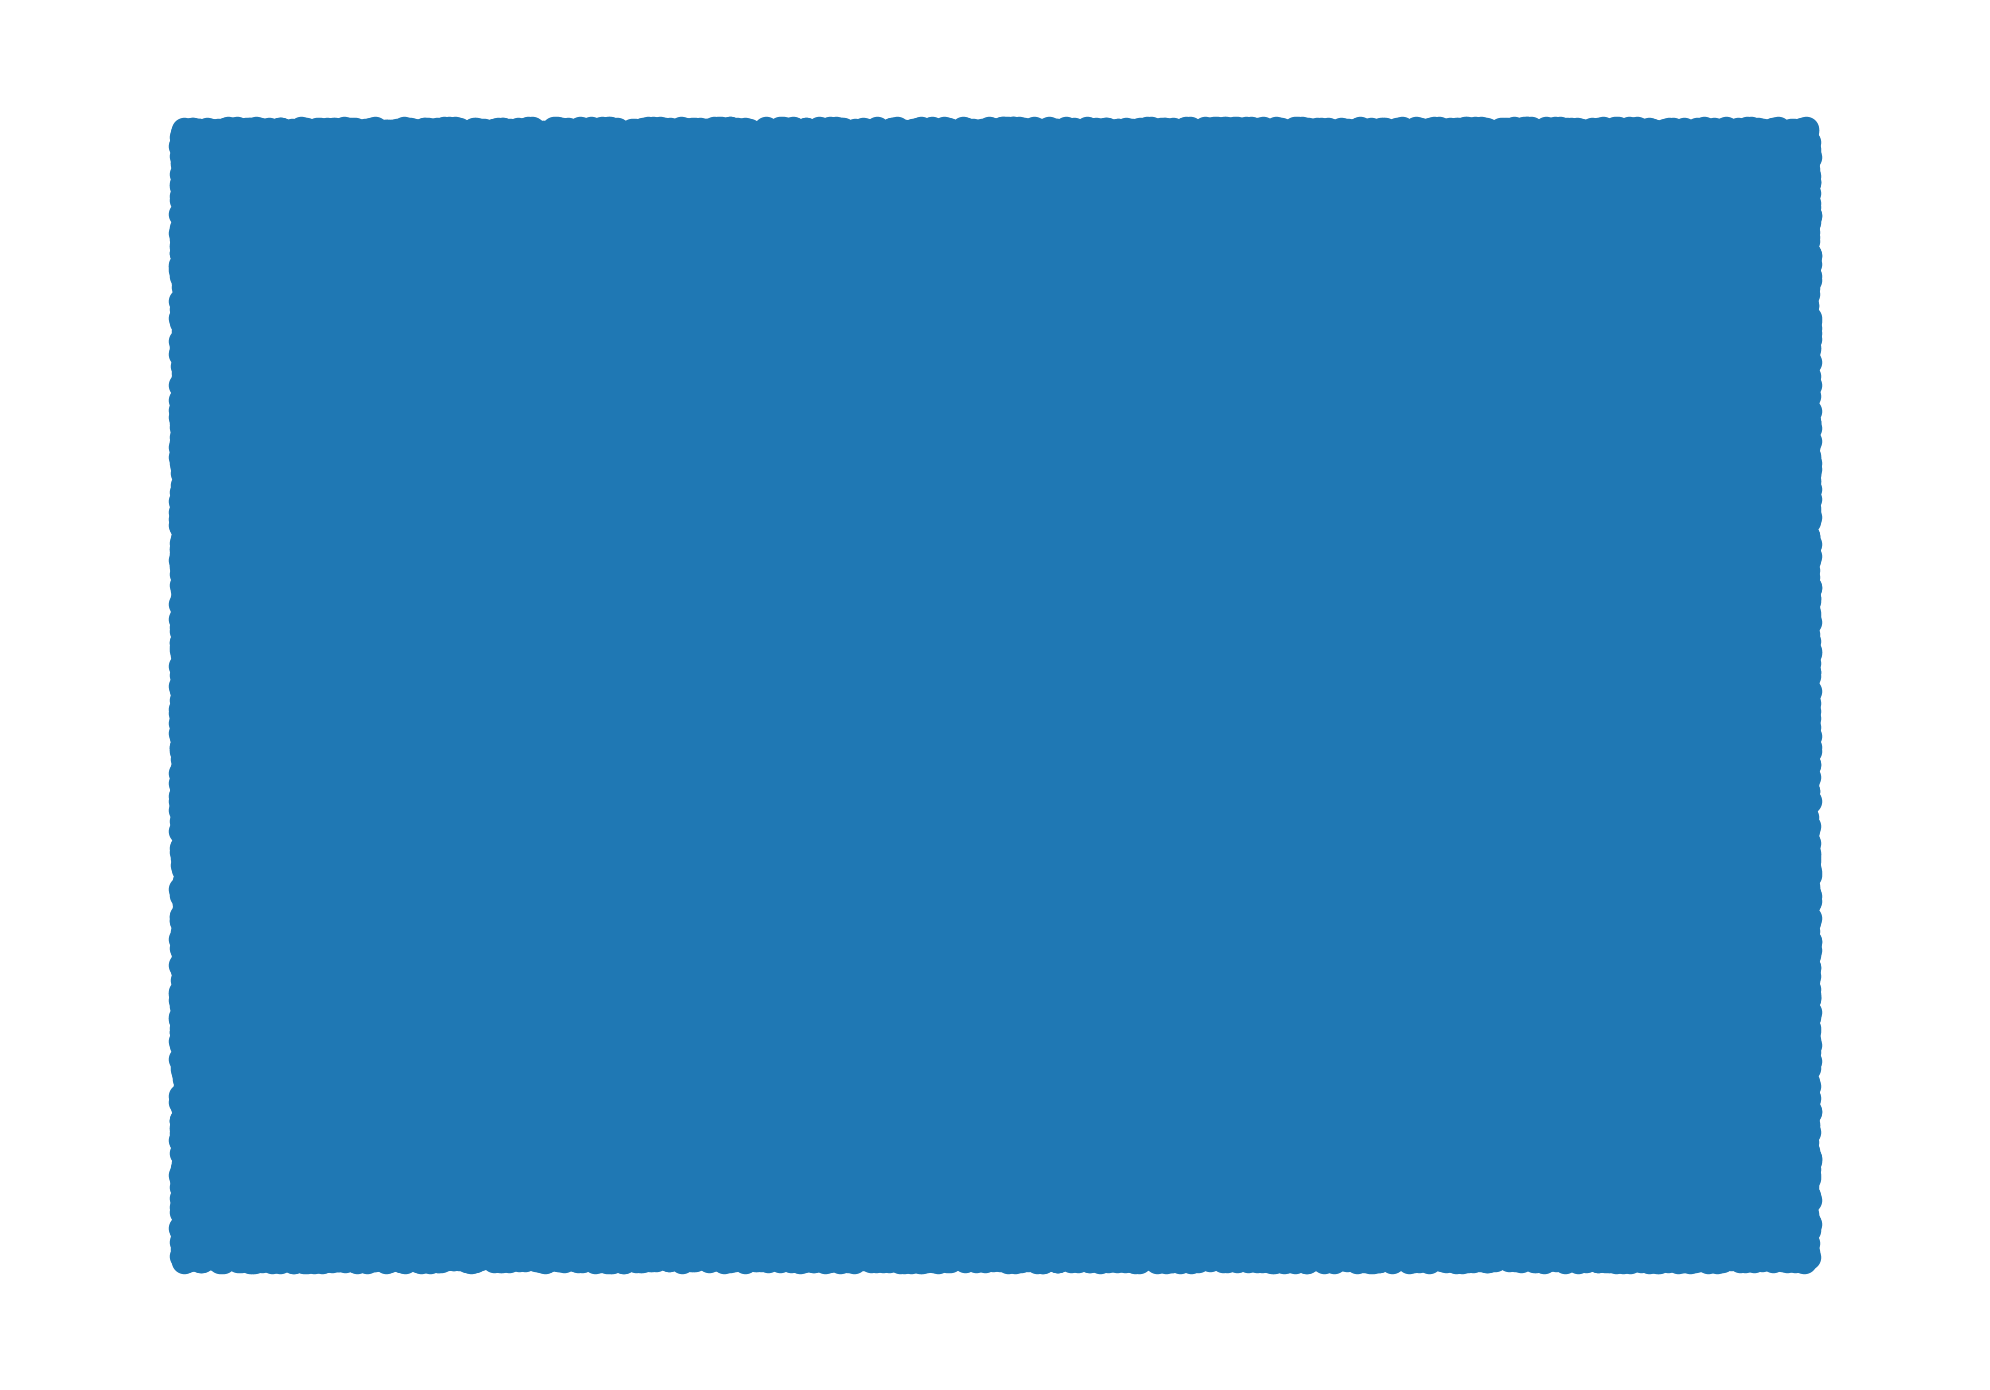

In [ ]:
# set figure size
plt.figure(figsize=(20,14))
# determine the positions using spring layout
pos = nx.random_layout(G)
nx.draw_networkx_edges(G,pos,edge_color='grey',
    alpha=0.5,width=2)


# nx.draw(g,pos)
nx.draw_networkx_nodes(G, pos)
# set tight layout
plt.tight_layout()
# remove axis
plt.axis('off')

plt.show()

In [79]:
nx.is_bipartite(G)

True

Graphing the bipartite graph reveals a densely connected network. However, without further manipulation, the plot alone doesn't provide much insight into its underlying structure.

## Implementing Island Method:

To extract key insights from the large network, I employed the island method, which forms subgraphs and highlights connections based on node weights.

In [80]:
#Code sourced from the Social Network Analysis for Startups 2021 edition
def trim_edges(g, weight=1):
  g2=nx.Graph()
  for f, to, edata in g.edges(data=True):
    if edata['weight'] > weight:
      g2.add_edge(f,to,weight = edata)
  return g2

In [81]:
#Code sourced from the Social Network Analysis for Startupds 2021 edition
def island_method(g, iterations=5):
  weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
  mn=int(min(weights))
  mx=int(max(weights))
  #compute the size of the step, so we get a reasonable step in iterations
  step=int((mx-mn)/iterations)
  return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]


## Using the Island Method:

The `G` network is not a connected network. There are however 7893 connected subgraphs in this network that could allow for further insights.

In [82]:
nx.is_connected(G)

False

In [83]:
##[len(c) for c in nx.connected_component_subgraphs(G) if len(c) > 10]
A = (G.subgraph(c) for c in nx.connected_components(G))
len(list(A))

7893

To apply the island method, I generated two bipartite weighted graphs using the `weighted_projected_graph()` function. The list below shows the weight—or number of connections—between each author, highlighting those who collaborated on at least one paper.

### Author's Island:

By making the graph a projection of just Author nodes, I am able to properly draw conclusions on the graph.

In [84]:
author_nodes = [a for a,d in G.nodes(data=True) if d['bipartite'] == 'authors']
weighted_author_graph = bi.weighted_projected_graph(G, author_nodes)
list(weighted_author_graph.edges(data=True))[0:10]


[('Author_50203', 'Author_4940', {'weight': 1}),
 ('Author_50203', 'Author_56358', {'weight': 1}),
 ('Author_50203', 'Author_57771', {'weight': 3}),
 ('Author_50203', 'Author_2990', {'weight': 2}),
 ('Author_50203', 'Author_25102', {'weight': 1}),
 ('Author_50203', 'Author_13826', {'weight': 7}),
 ('Author_50203', 'Author_65428', {'weight': 1}),
 ('Author_50203', 'Author_69437', {'weight': 1}),
 ('Author_50203', 'Author_41807', {'weight': 1}),
 ('Author_33399', 'Author_29791', {'weight': 1})]

Using the triangles functions, I can see the how many authors are clustered in triangles.

In [85]:
dict((list(nx.triangles(weighted_author_graph).items()))[0:10])

{'Author_50203': 4,
 'Author_33399': 0,
 'Author_29791': 14,
 'Author_24663': 80,
 'Author_43104': 1,
 'Author_6604': 38,
 'Author_19828': 2,
 'Author_5644': 187,
 'Author_52804': 0,
 'Author_1968': 13}

In [86]:
len(list(nx.connected_components(weighted_author_graph)))

7893

There are 7,893 connected components, indicating that 7,893 distinct groups of authors have collaborated on at least one paper together.

A preview of the degree centrality for the author nodes are shown below.

In [87]:
dict((list(nx.degree_centrality(weighted_author_graph).items()))[0:10])


{'Author_50203': 0.000127237255068284,
 'Author_33399': 1.4137472785364888e-05,
 'Author_29791': 0.0004241241835609466,
 'Author_24663': 0.0008058359487657986,
 'Author_43104': 2.8274945570729776e-05,
 'Author_6604': 0.00040998671077558177,
 'Author_19828': 5.654989114145955e-05,
 'Author_5644': 0.0013289224418242995,
 'Author_52804': 1.4137472785364888e-05,
 'Author_1968': 0.000254474510136568}

In [88]:
[len(c) for c in nx.connected_components(weighted_author_graph) if len(c) > 10][0:10]

[54112, 17, 15, 12, 14, 19, 11, 13, 12, 15]

Additionally, the author's graph is not fully connected, which indicates that there isn't a single paper linking all authors together. By employing list comprehension, I identified the various connected components within the graph. Notably, the largest connected component contains 54,112 nodes. Given that one giant component encompasses over 54,000 nodes, the textbook suggests treating this component as representative of the entire network. This giant component appears as the first element when using the `connected_components` function.

In [89]:
S = [weighted_author_graph.subgraph(c).copy() for c in nx.connected_components(weighted_author_graph)]

In [90]:
nx.is_connected(S[0])

True

Now I can use the island method on this connected component to analyze this large network closer.

In [91]:
island_authors = island_method(S[0])

In [92]:
for i in island_authors:
  print("Threshold:",i[0], "Size:",len(i[1]), "Connections:", len(list(nx.connected_components(i[1]))))


Threshold: 1 Size: 16667 Connections: 1250
Threshold: 13 Size: 304 Connections: 121
Threshold: 25 Size: 35 Connections: 16
Threshold: 37 Size: 10 Connections: 5
Threshold: 49 Size: 6 Connections: 3
Threshold: 61 Size: 2 Connections: 1


By using the `island_method` I was able to divide by 6 thresholds. This threshold can be specified in the function, but for this project I will keep it simple.

Next I created islands at the first threshold.
The first threshold has 1,250 connections (also known as edges) and the graph's size was 16,667 nodes.

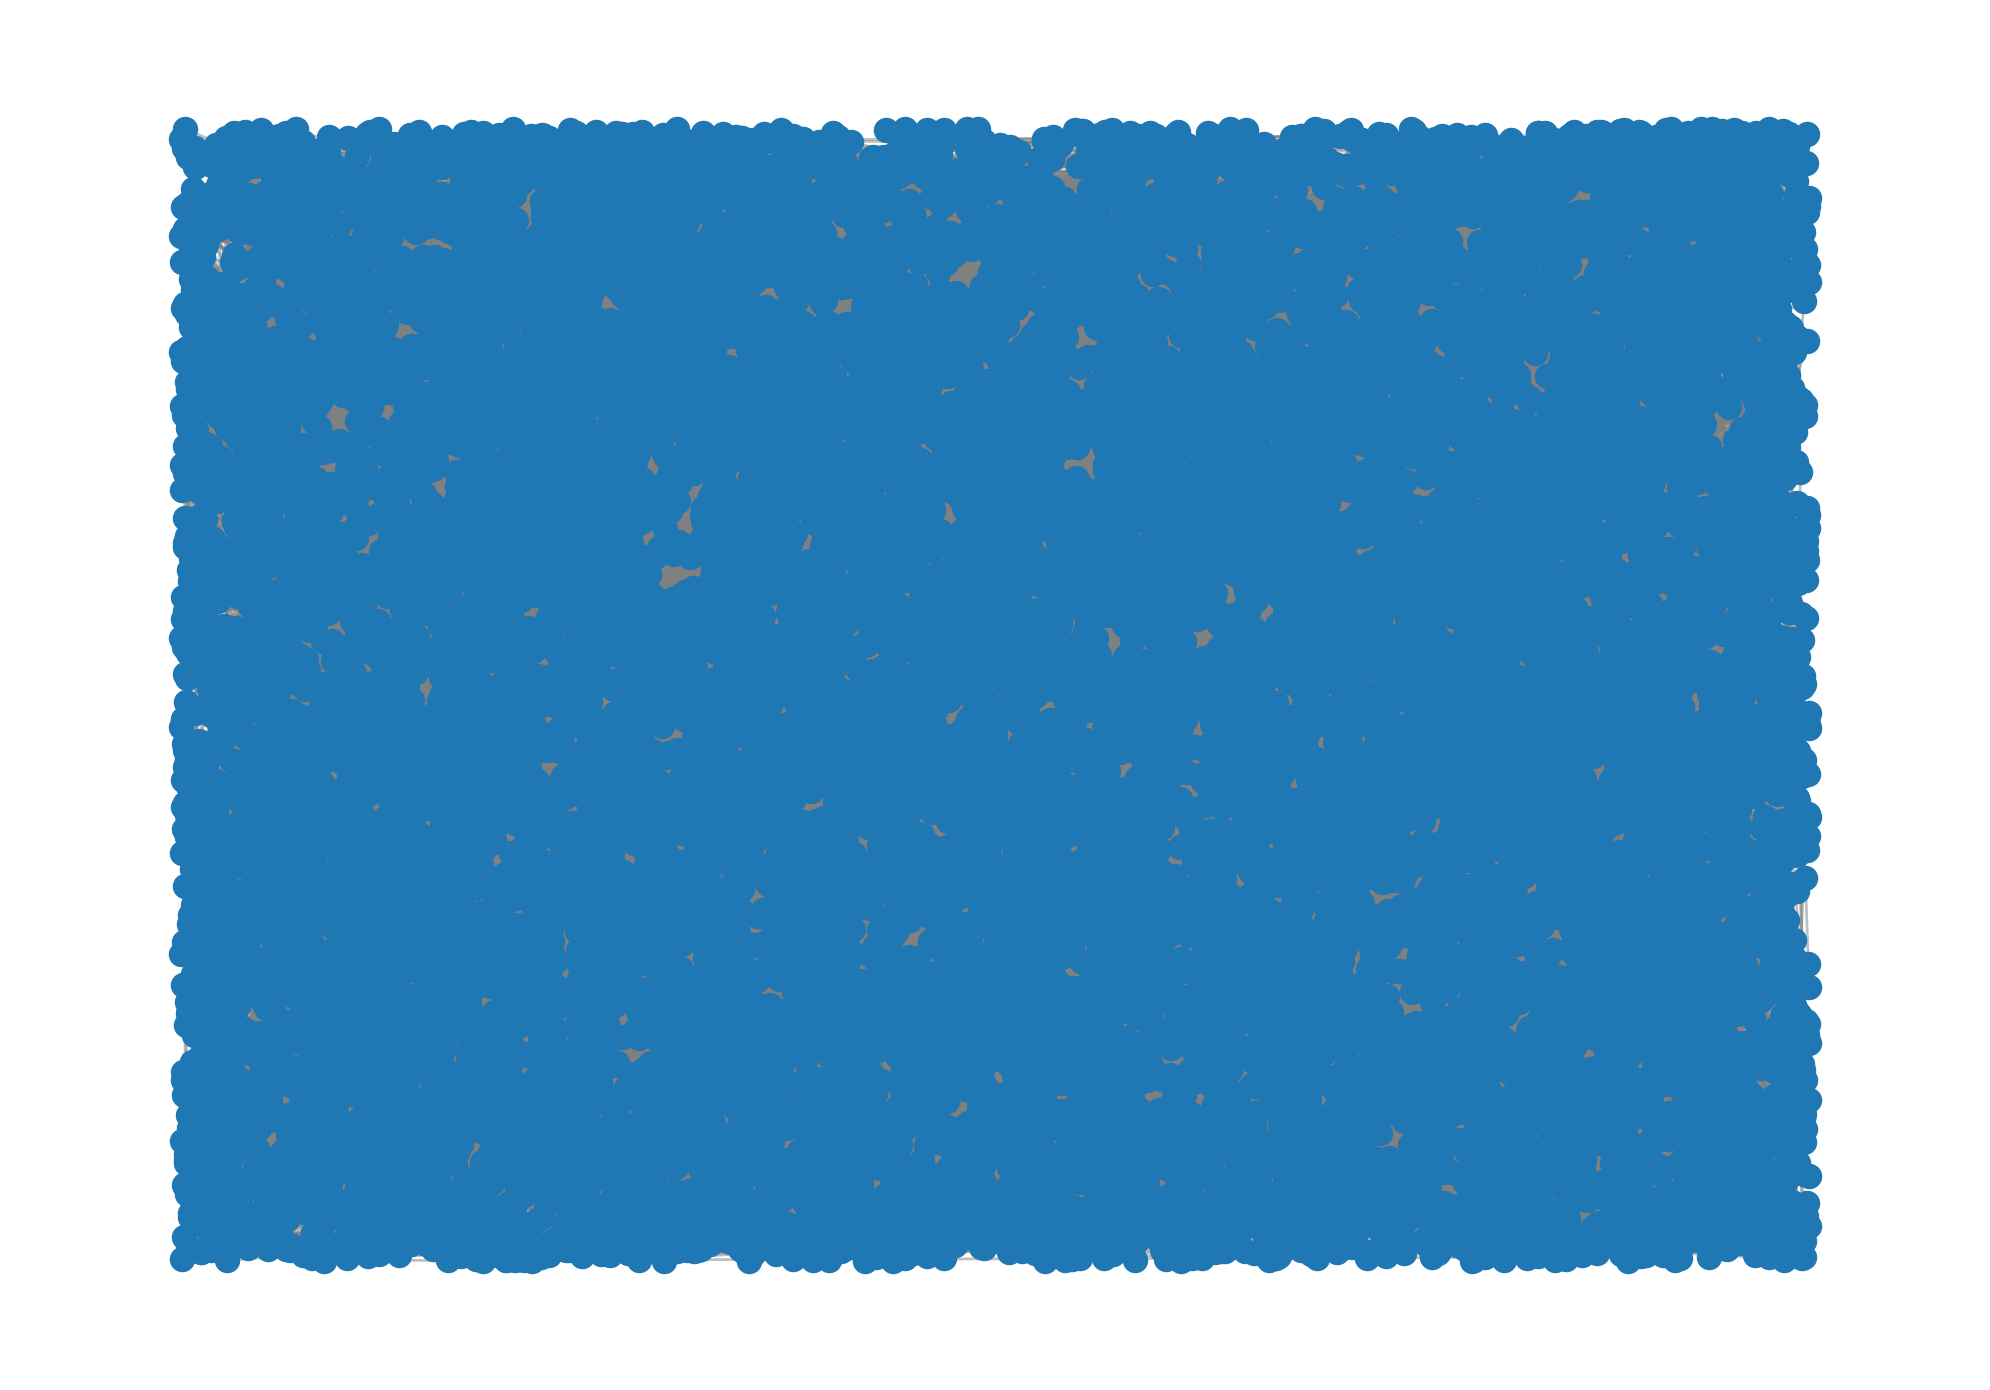

In [93]:
subgraph = island_authors[0][1]
# set figure size
plt.figure(figsize=(20,14))
# determine the positions using spring layout
pos = nx.random_layout(subgraph)
nx.draw_networkx_edges(subgraph,pos,edge_color='grey',
    alpha=0.5,width=2)


# nx.draw(g,pos)
nx.draw_networkx_nodes(subgraph, pos)
# set tight layout
plt.tight_layout()
# remove axis
plt.axis('off')

plt.show()

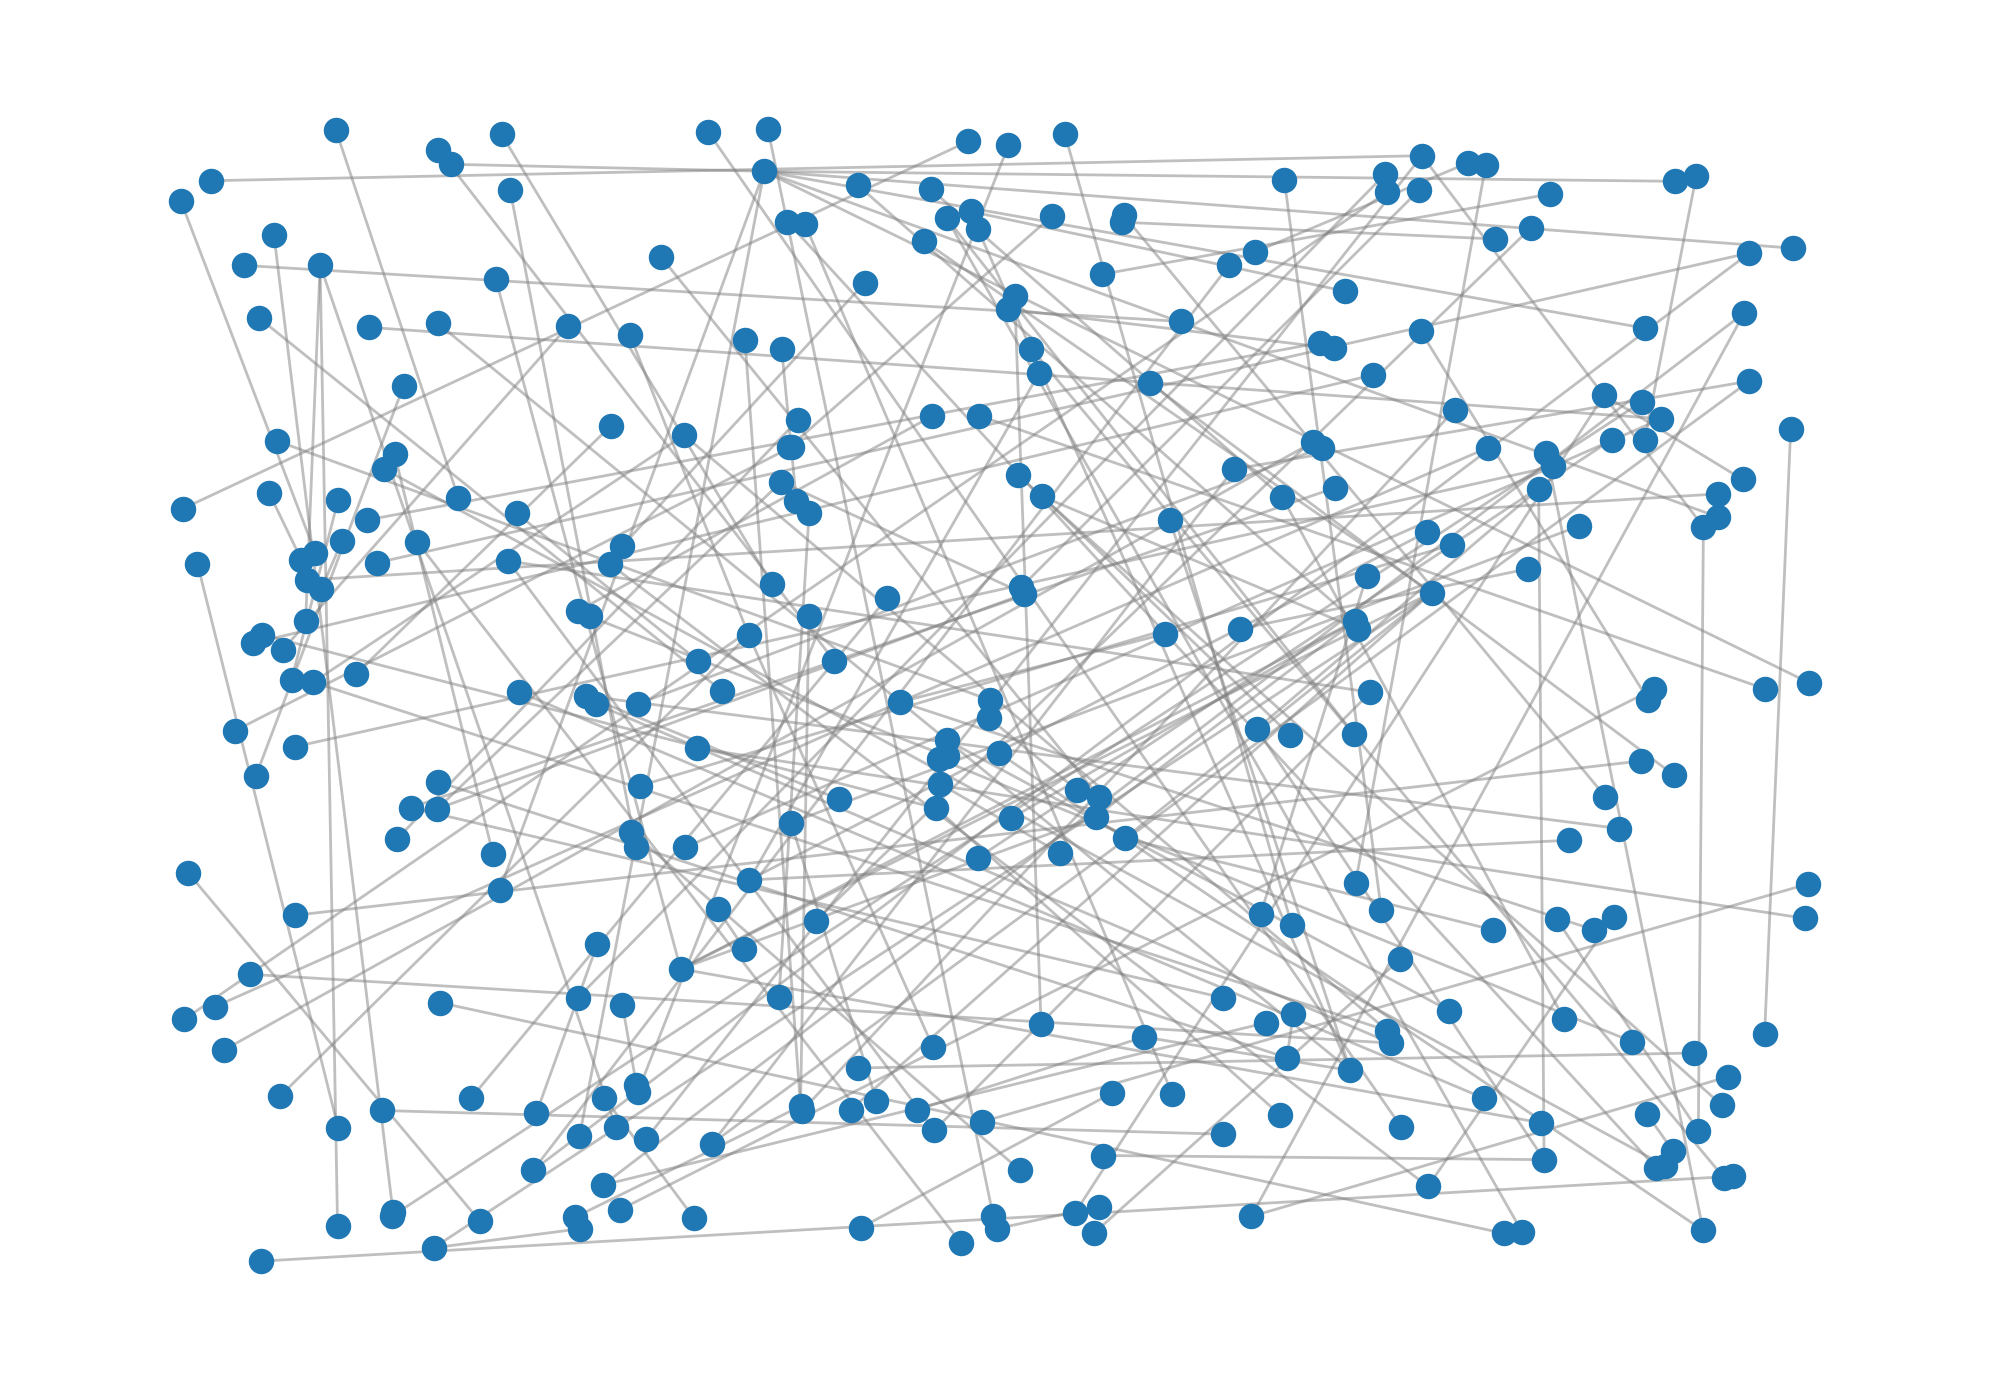

In [94]:
subgraph = island_authors[1][1]
# set figure size
plt.figure(figsize=(20,14))
# determine the positions using spring layout
pos = nx.random_layout(subgraph)
nx.draw_networkx_edges(subgraph,pos,edge_color='grey',
    alpha=0.5,width=2)


# nx.draw(g,pos)
nx.draw_networkx_nodes(subgraph, pos)
# set tight layout
plt.tight_layout()
# remove axis
plt.axis('off')

plt.show()

At the next threshold, the graph becomes less dense; however, this reduction still doesn't allow for any clear visual conclusions.

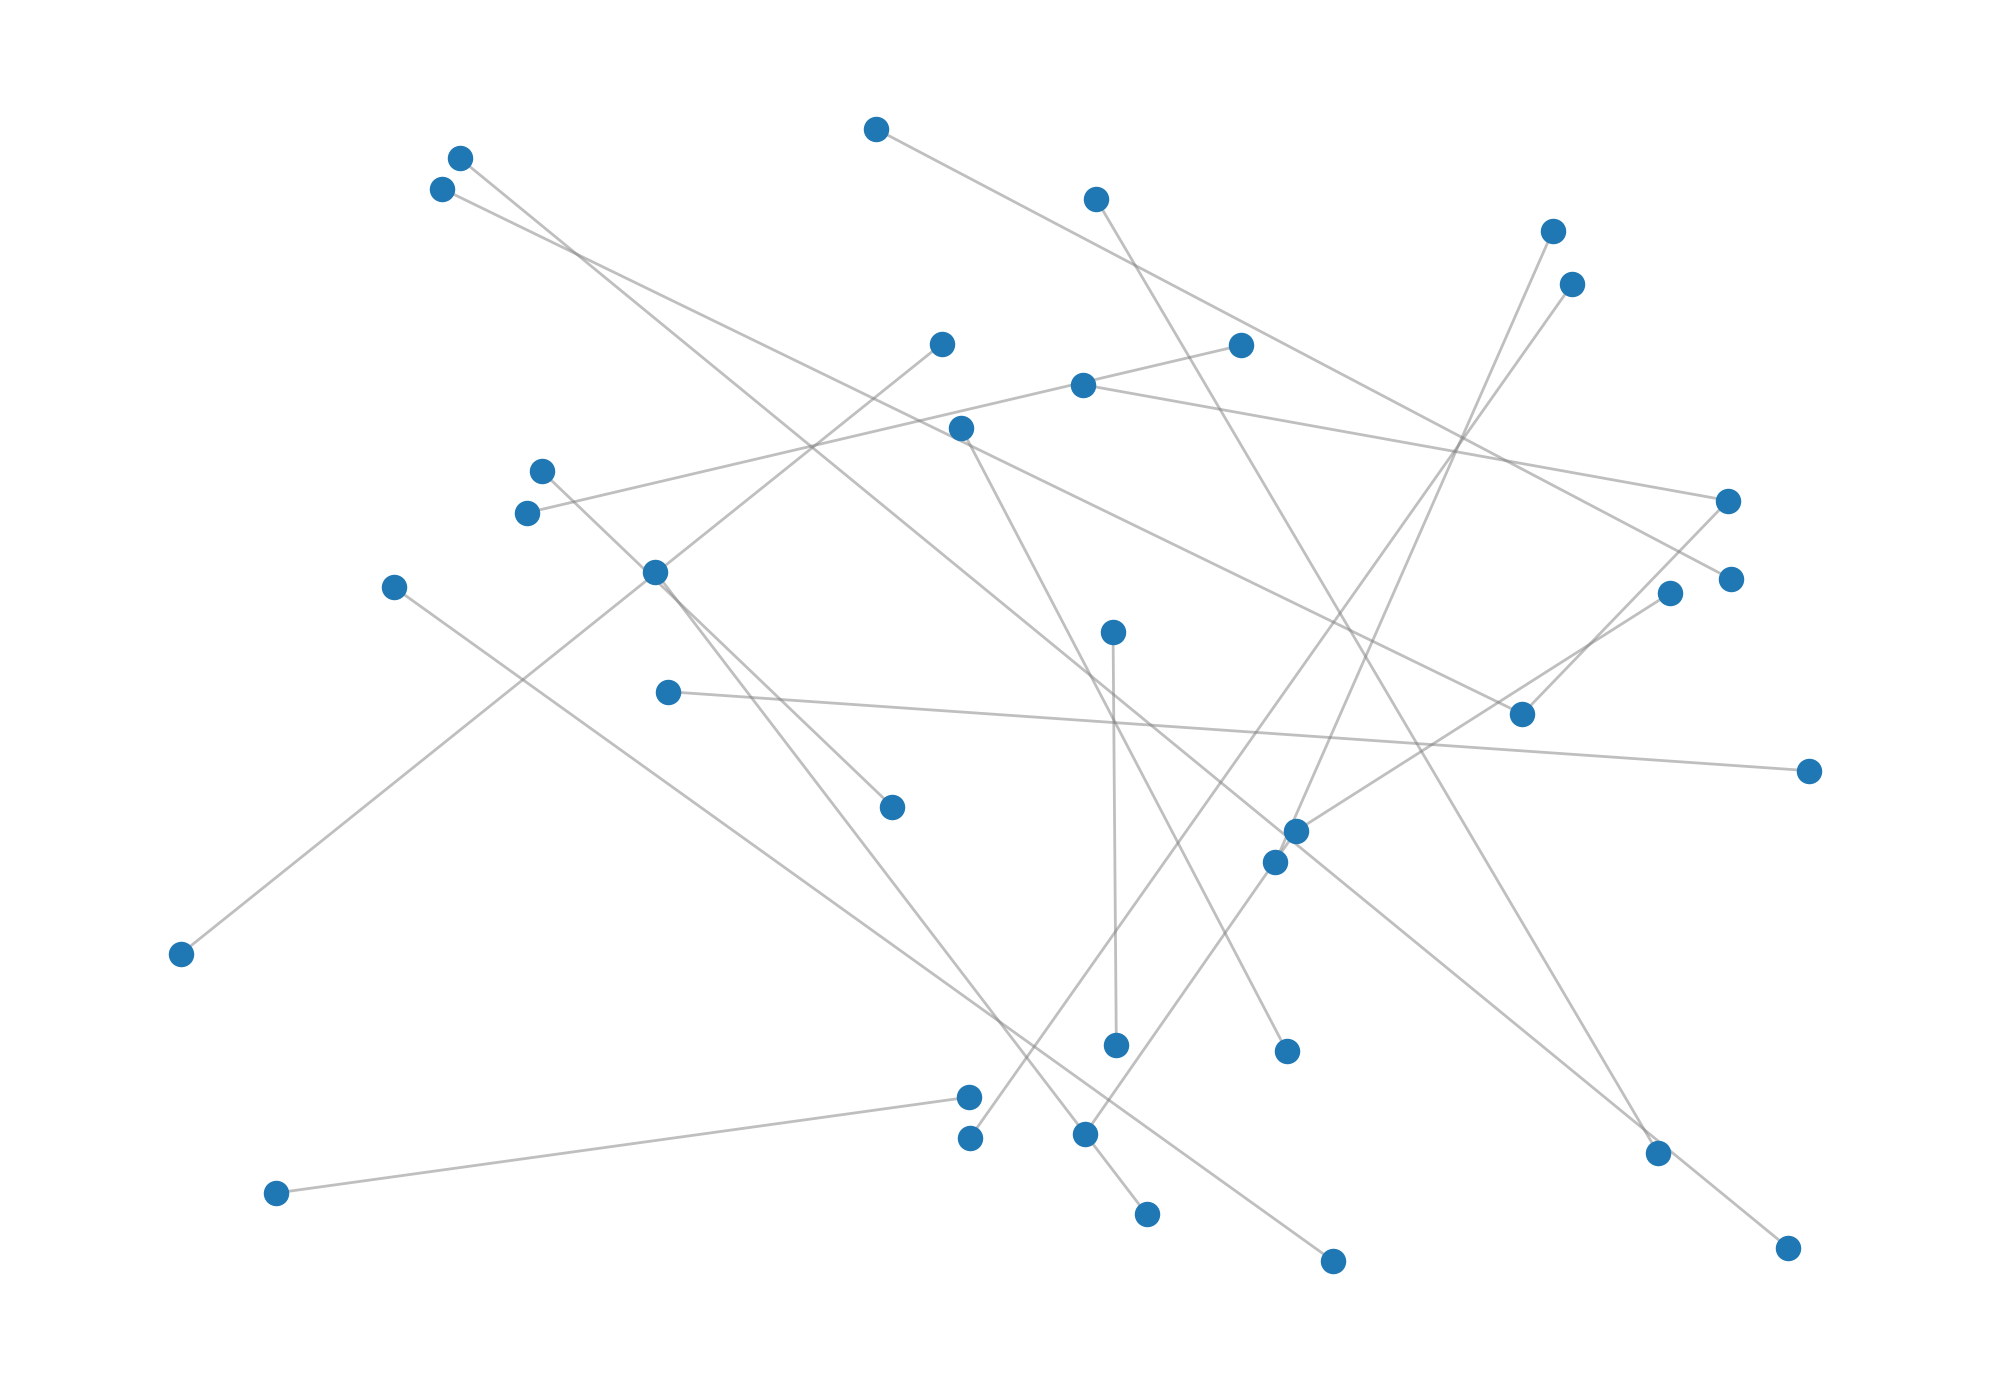

In [95]:
subgraph = island_authors[2][1]
# set figure size
plt.figure(figsize=(20,14))
# determine the positions using spring layout
pos = nx.random_layout(subgraph)
nx.draw_networkx_edges(subgraph,pos,edge_color='grey',
    alpha=0.5,width=2)


# nx.draw(g,pos)
nx.draw_networkx_nodes(subgraph, pos)
# set tight layout
plt.tight_layout()
# remove axis
plt.axis('off')

plt.show()

At this threshold, the structure of the islands and their interconnections becomes much clearer, allowing for more detailed visual analysis. For example, some islands consist of as few as two nodes, while others include up to four nodes.

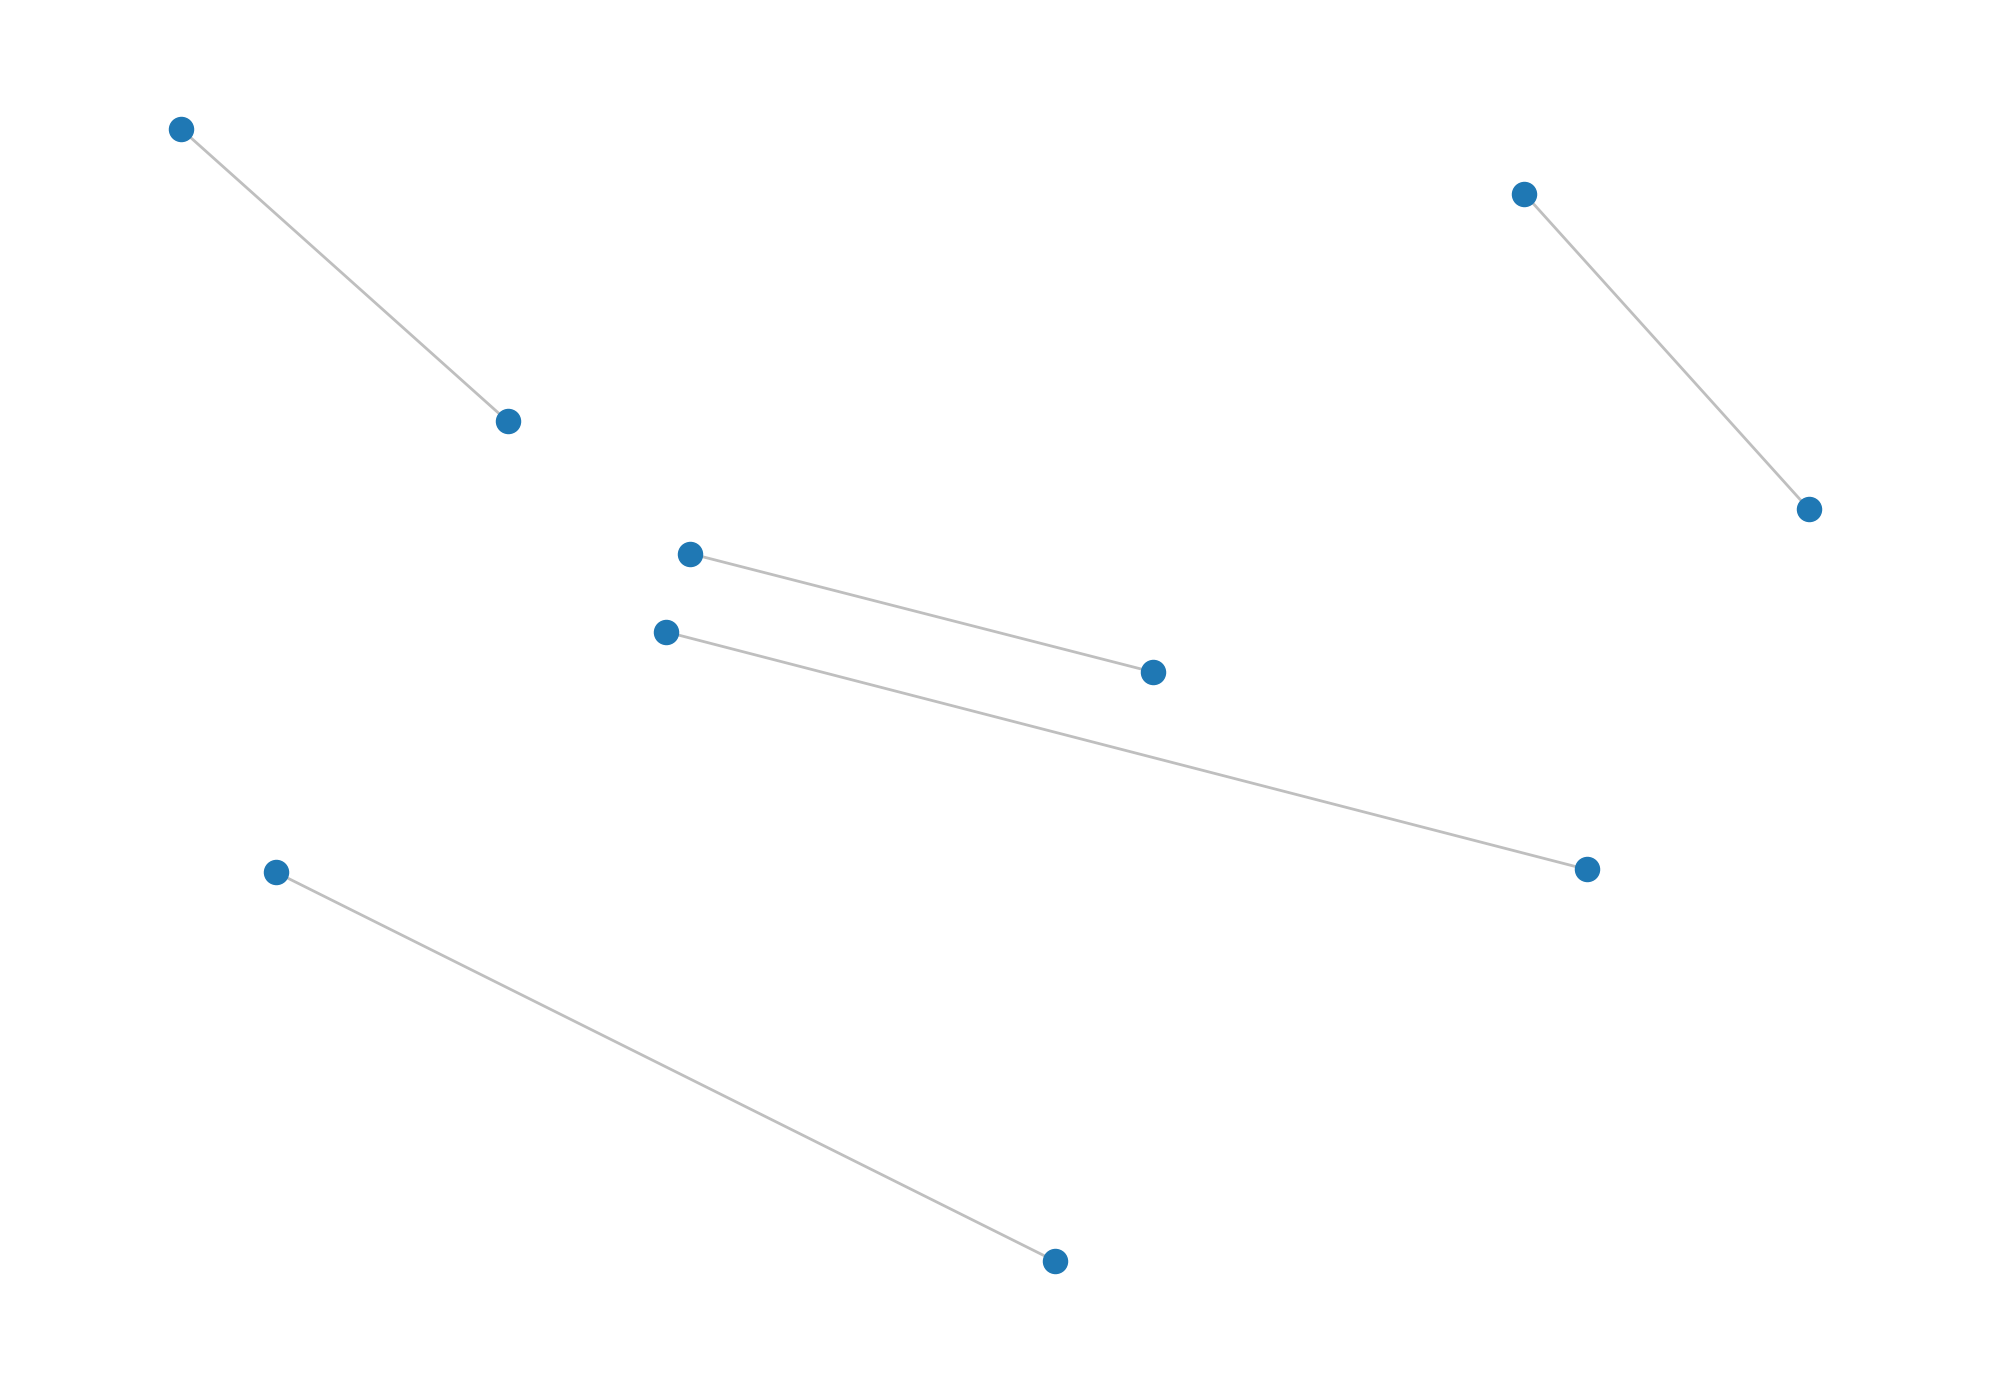

In [96]:
subgraph = island_authors[3][1]
# set figure size
plt.figure(figsize=(20,14))
# determine the positions using spring layout
pos = nx.random_layout(subgraph)
nx.draw_networkx_edges(subgraph,pos,edge_color='grey',
    alpha=0.5,width=2)


# nx.draw(g,pos)
nx.draw_networkx_nodes(subgraph, pos)
# set tight layout
plt.tight_layout()
# remove axis
plt.axis('off')

plt.show()

At higher thresholds, fewer connections exist between the author nodes. At this level, every island consists solely of two nodes.

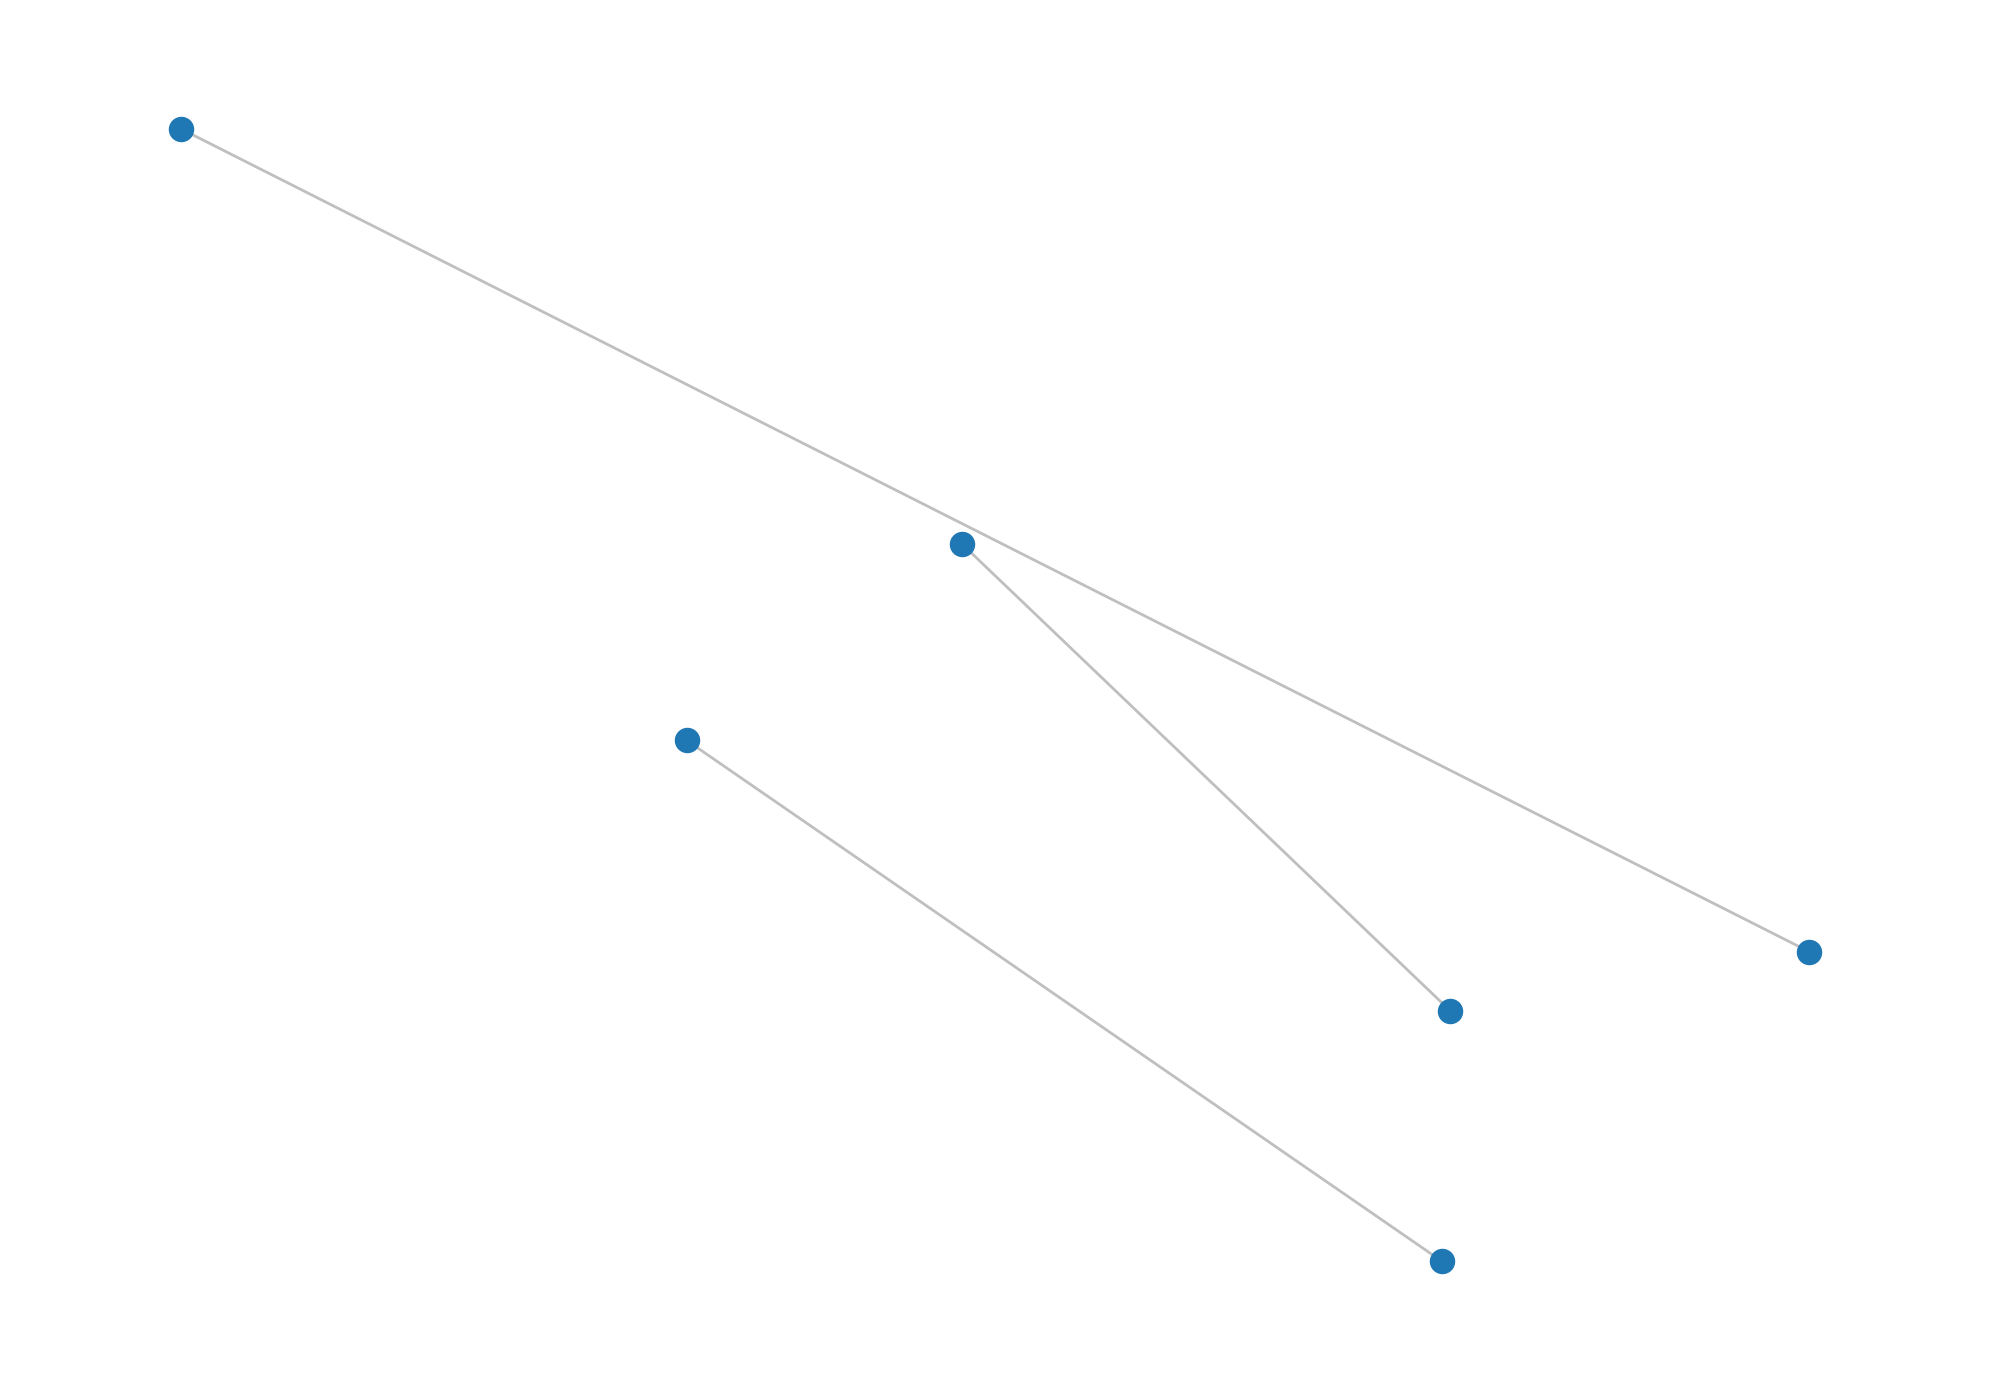

In [97]:
subgraph = island_authors[4][1]
# set figure size
plt.figure(figsize=(20,14))
# determine the positions using spring layout
pos = nx.random_layout(subgraph)
nx.draw_networkx_edges(subgraph,pos,edge_color='grey',
    alpha=0.5,width=2)


# nx.draw(g,pos)
nx.draw_networkx_nodes(subgraph, pos)
# set tight layout
plt.tight_layout()
# remove axis
plt.axis('off')

plt.show()

This second to last threshold only shows two islands.

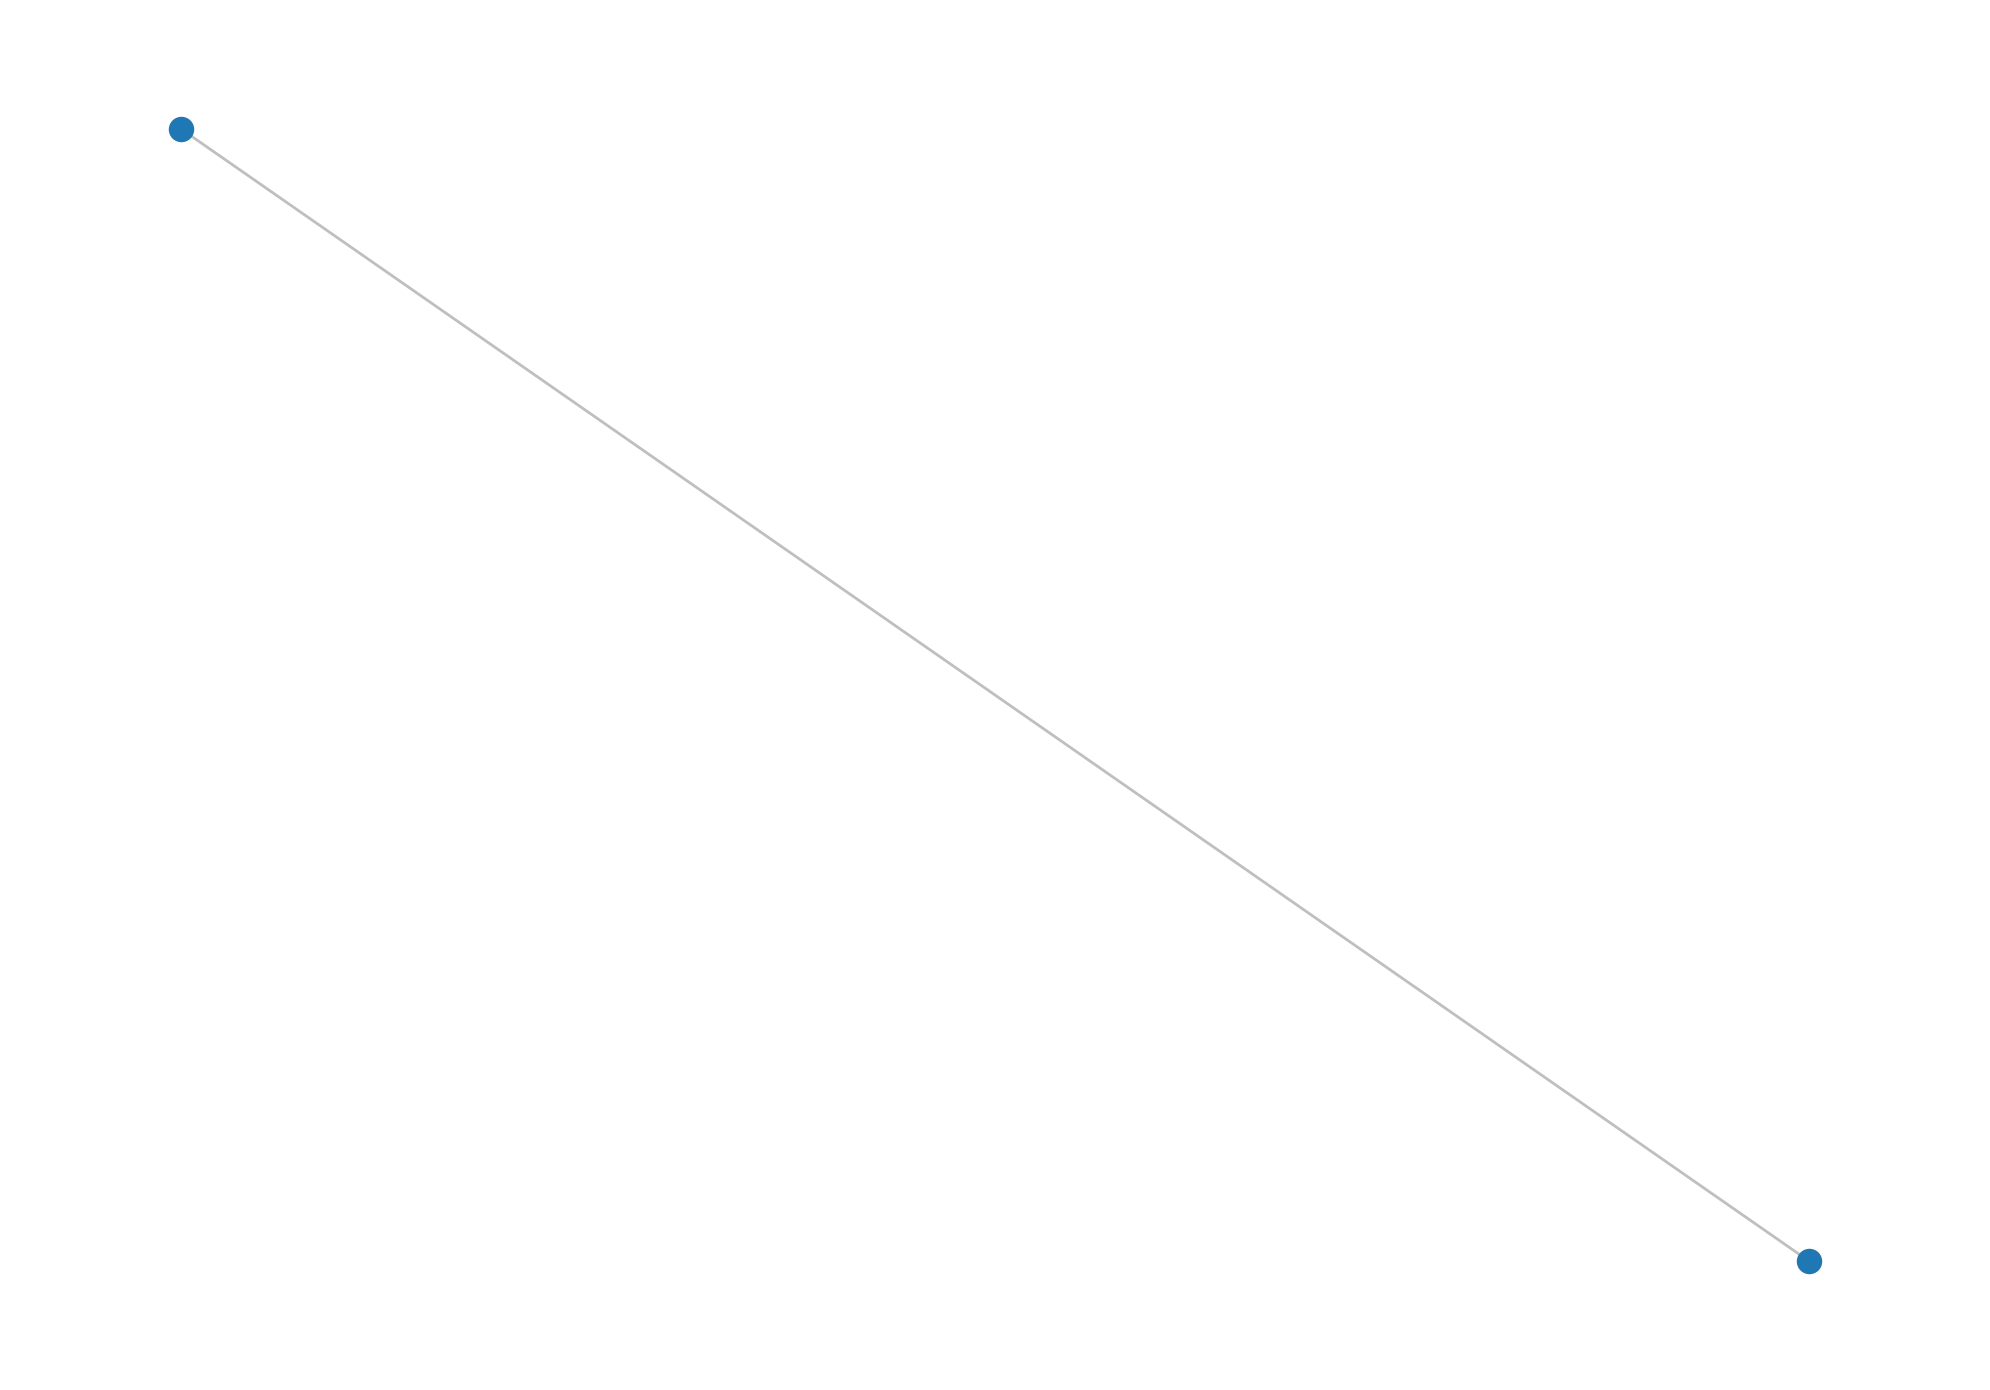

In [98]:
subgraph = island_authors[5][1]
# set figure size
plt.figure(figsize=(20,14))
# determine the positions using spring layout
pos = nx.random_layout(subgraph)
nx.draw_networkx_edges(subgraph,pos,edge_color='grey',
    alpha=0.5,width=2)


# nx.draw(g,pos)
nx.draw_networkx_nodes(subgraph, pos)
# set tight layout
plt.tight_layout()
# remove axis
plt.axis('off')

plt.show()

The island graph reveals that authors are connected through shared papers. The initial graph `G` was too dense to discern these individual connections, but the island method clarifies the relationships. This analysis shows that, at a weight threshold of 1, the maximum number of authors collaborating on a single paper is 1,250.

### Papers' Island:

Next, I'll apply the same methodology used for the author nodes to the paper nodes.

In [99]:
paper_nodes = [a for a,d in G.nodes(data=True) if d['bipartite'] == 'papers']
weighted_paper_graph = bi.weighted_projected_graph(G, paper_nodes)
list(weighted_paper_graph.edges(data=True))[0:20]

[('Paper_1', 'Paper_79482', {'weight': 1}),
 ('Paper_1', 'Paper_96984', {'weight': 1}),
 ('Paper_1', 'Paper_44301', {'weight': 1}),
 ('Paper_1', 'Paper_40702', {'weight': 1}),
 ('Paper_1', 'Paper_43393', {'weight': 1}),
 ('Paper_1', 'Paper_42430', {'weight': 1}),
 ('Paper_1', 'Paper_28420', {'weight': 1}),
 ('Paper_1', 'Paper_8484', {'weight': 1}),
 ('Paper_1', 'Paper_44405', {'weight': 1}),
 ('Paper_1', 'Paper_36872', {'weight': 1}),
 ('Paper_1', 'Paper_9361', {'weight': 1}),
 ('Paper_1', 'Paper_80688', {'weight': 1}),
 ('Paper_1', 'Paper_64223', {'weight': 1}),
 ('Paper_1', 'Paper_28147', {'weight': 1}),
 ('Paper_1', 'Paper_8856', {'weight': 1}),
 ('Paper_1', 'Paper_63176', {'weight': 1}),
 ('Paper_1', 'Paper_38586', {'weight': 1}),
 ('Paper_1', 'Paper_42513', {'weight': 1}),
 ('Paper_1', 'Paper_8909', {'weight': 1}),
 ('Paper_1', 'Paper_9795', {'weight': 1})]

There are 7893 connected components in the weighted paper graph.

In [100]:
len(list(nx.connected_components(weighted_paper_graph)))

7893

In [101]:
paper_triangles = nx.triangles(weighted_paper_graph)

In [102]:
dict((list(paper_triangles.items()))[0:10])

{'Paper_1': 861,
 'Paper_2': 862,
 'Paper_3': 6786,
 'Paper_4': 383,
 'Paper_5': 6349,
 'Paper_6': 1,
 'Paper_7': 616,
 'Paper_8': 29,
 'Paper_9': 1821,
 'Paper_10': 55}

The weighted paper graph shows that there are triangles in this projections. The paper with the maximum amount of triangles it was apart of is Paper 8394.

In [103]:
max(paper_triangles, key= lambda x: paper_triangles[x])

'Paper_83294'

The degree centrality is saved to `paper_dc`.

In [104]:
paper_dc = nx.degree_centrality(weighted_paper_graph)

In [105]:
max(paper_dc, key= lambda x: paper_dc[x])

'Paper_83294'

The paper with the maximum degree centrality is again Paper 83294.

In [106]:
dict((list(paper_triangles.items()))[0:10])


{'Paper_1': 861,
 'Paper_2': 862,
 'Paper_3': 6786,
 'Paper_4': 383,
 'Paper_5': 6349,
 'Paper_6': 1,
 'Paper_7': 616,
 'Paper_8': 29,
 'Paper_9': 1821,
 'Paper_10': 55}

The degree centrality shows the importance of each nodes by the number of connections it has.

In [107]:
[len(c) for c in nx.connected_components(weighted_paper_graph) if len(c) > 10][0:10]

[84407, 18, 23, 19, 17, 18, 21, 16, 12, 11]

The largest connected subgraph has 88407 components in it.

In [108]:
S = [weighted_paper_graph.subgraph(c).copy() for c in nx.connected_components(weighted_paper_graph)]

Utilizing the island method with a threshold of 5, we show at least 6 different graphs below.

In [109]:
island_papers = island_method(S[0])

In [110]:
island_papers

[[1, <networkx.classes.graph.Graph at 0x2af1ef50ee0>],
 [5, <networkx.classes.graph.Graph at 0x2af01382a10>],
 [9, <networkx.classes.graph.Graph at 0x2af1555df60>],
 [13, <networkx.classes.graph.Graph at 0x2af1ef50520>],
 [17, <networkx.classes.graph.Graph at 0x2af1ef518d0>],
 [21, <networkx.classes.graph.Graph at 0x2af1ef504c0>]]

In [111]:
for i in island_papers:
  print("Threshold:",i[0], "Size:",len(i[1]), "Connections:", len(list(nx.connected_components(i[1]))))

Threshold: 1 Size: 41452 Connections: 8244
Threshold: 5 Size: 41 Connections: 18
Threshold: 9 Size: 2 Connections: 1
Threshold: 13 Size: 2 Connections: 1
Threshold: 17 Size: 2 Connections: 1
Threshold: 21 Size: 2 Connections: 1


When applying the island method to the papers graph, we observe very few connected components with weights above 1. Multiple connections are only evident at the first two thresholds, with the largest paper network emerging at threshold 1. In this context, a connection between papers indicates they were written by the same author.

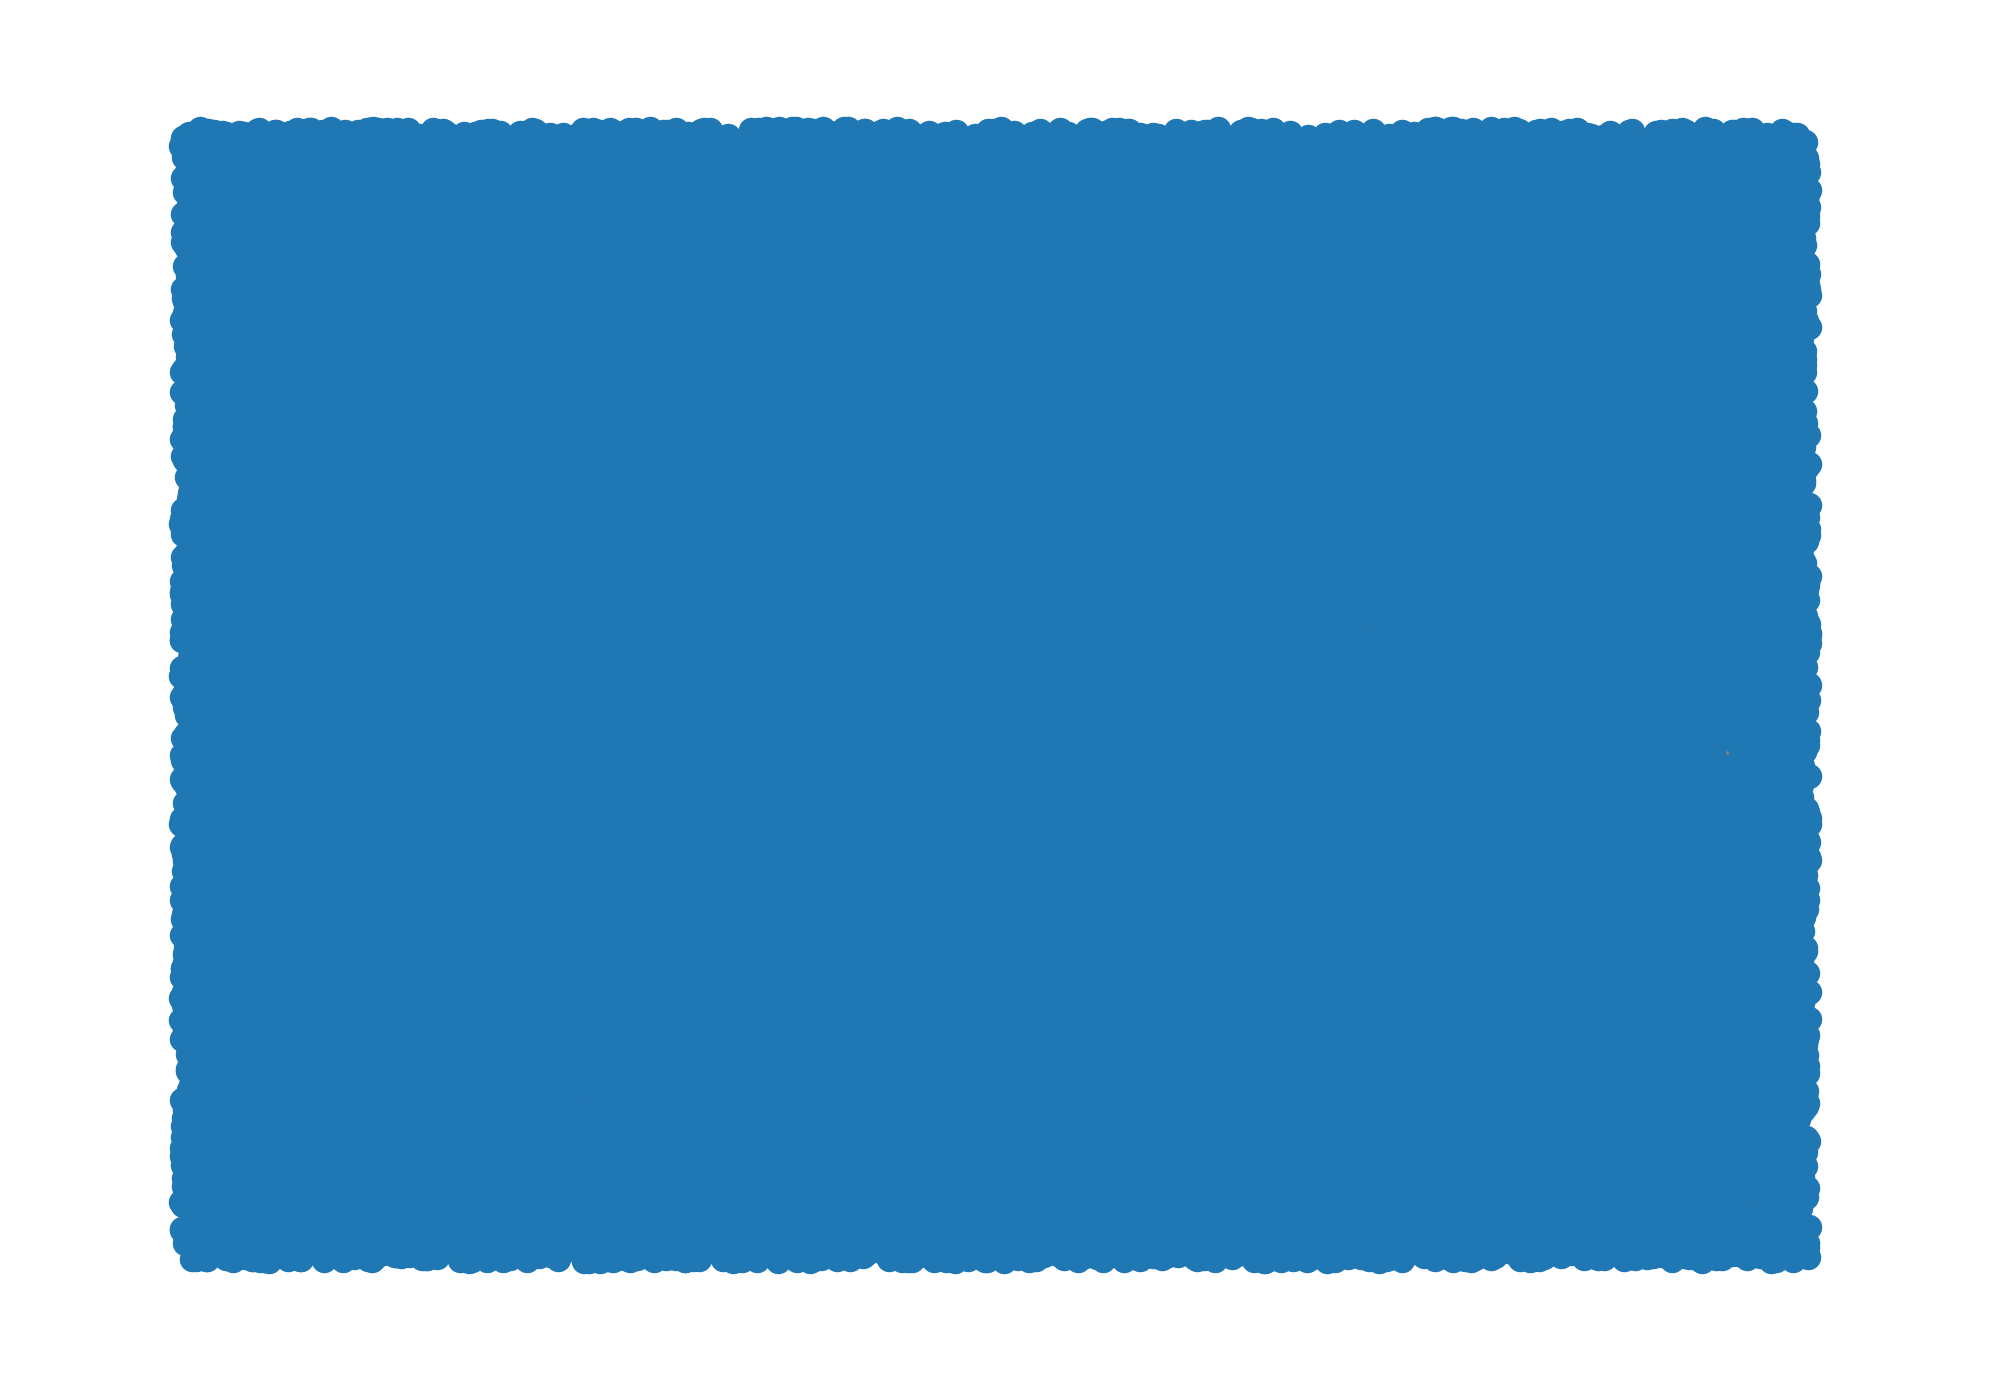

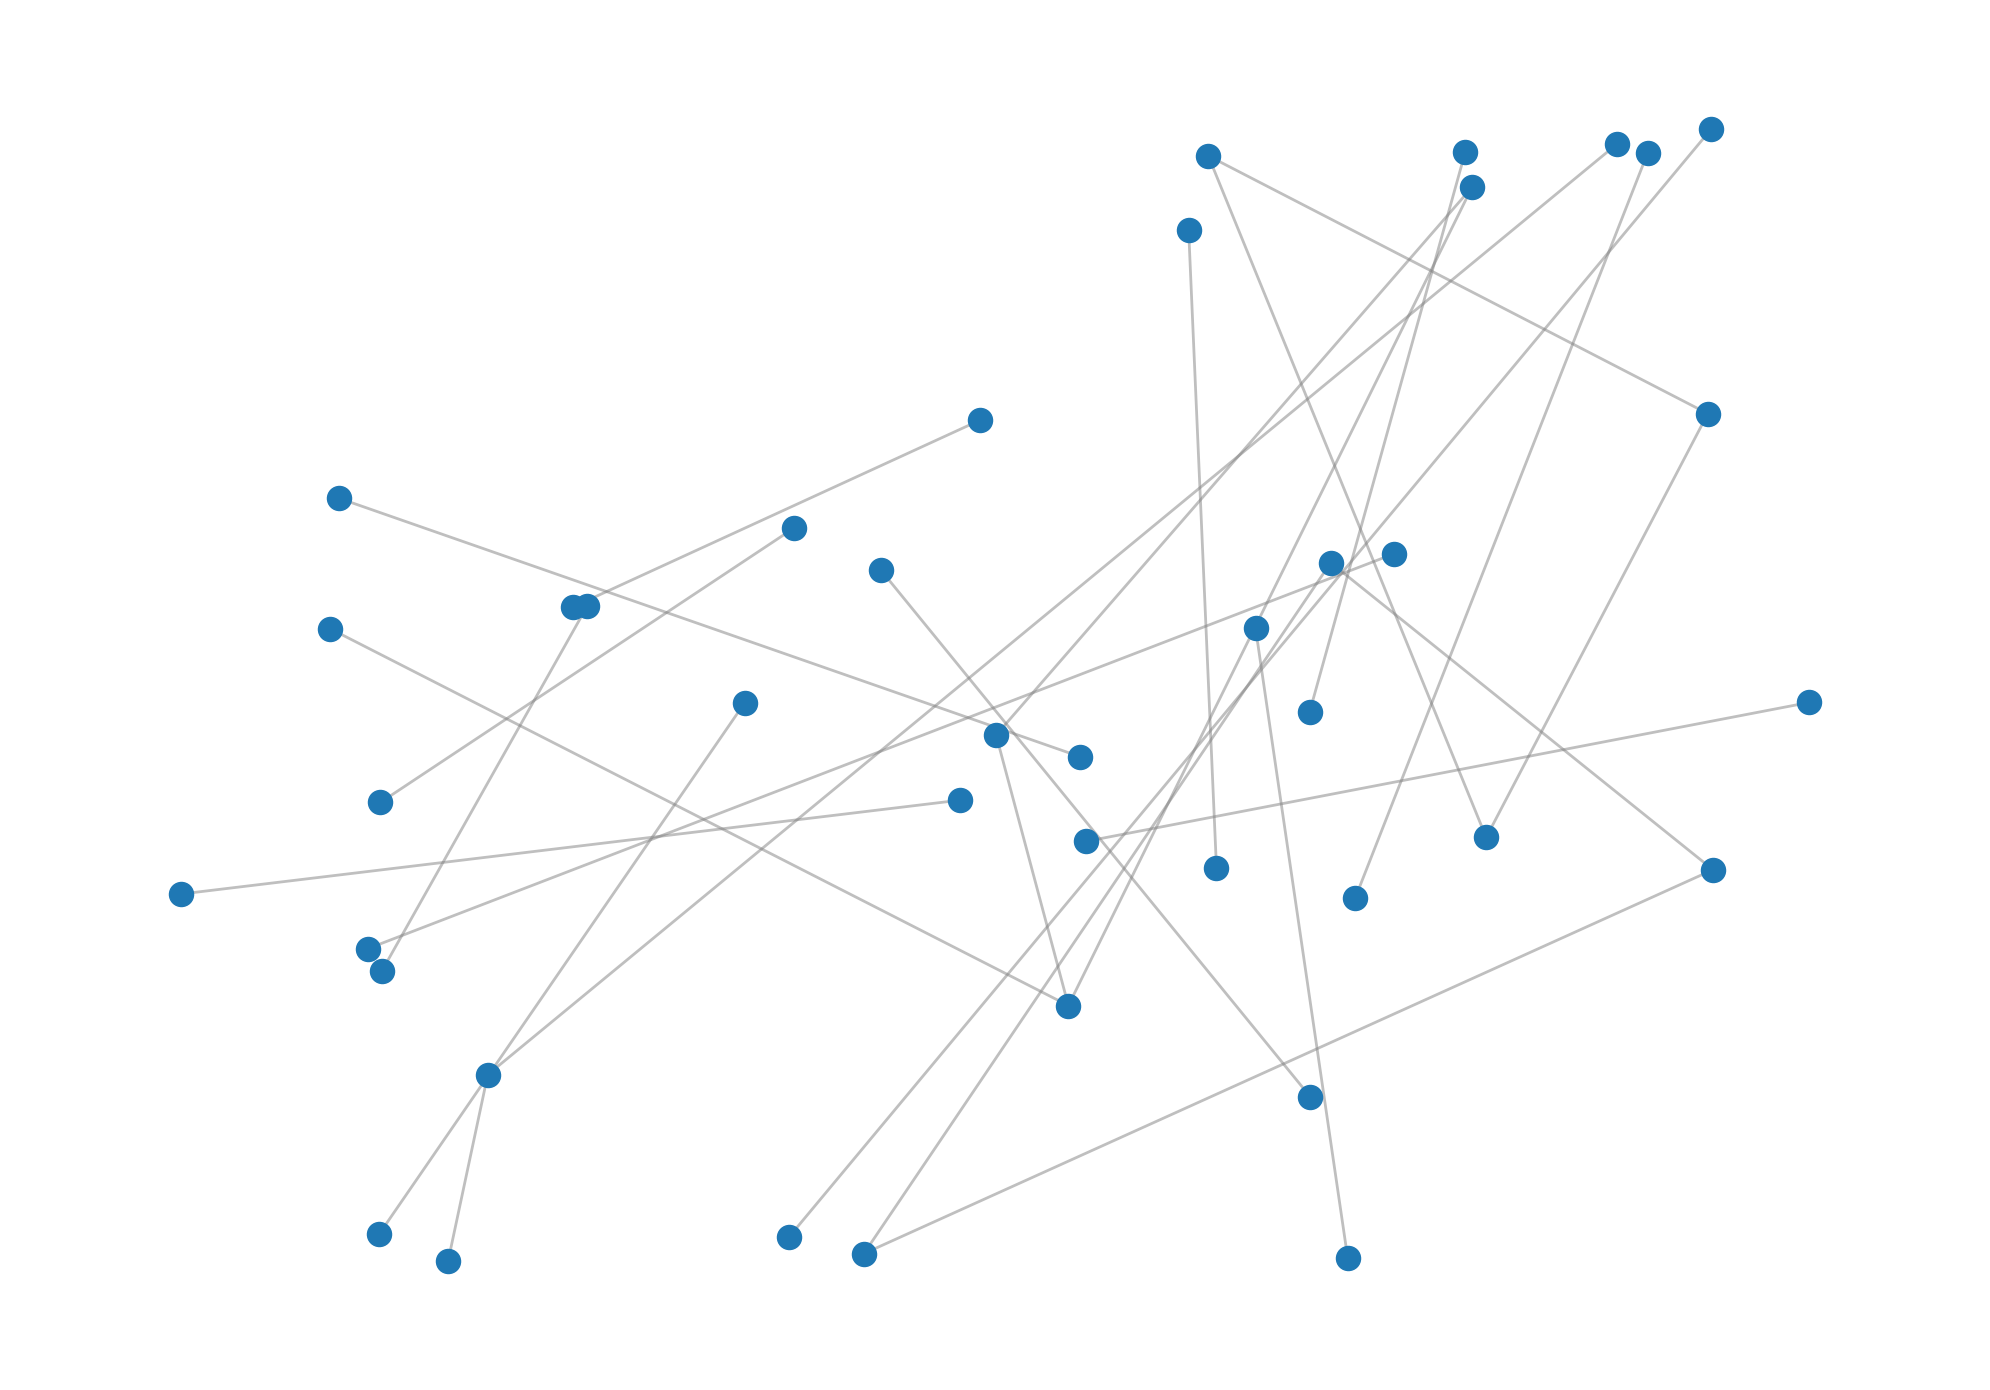

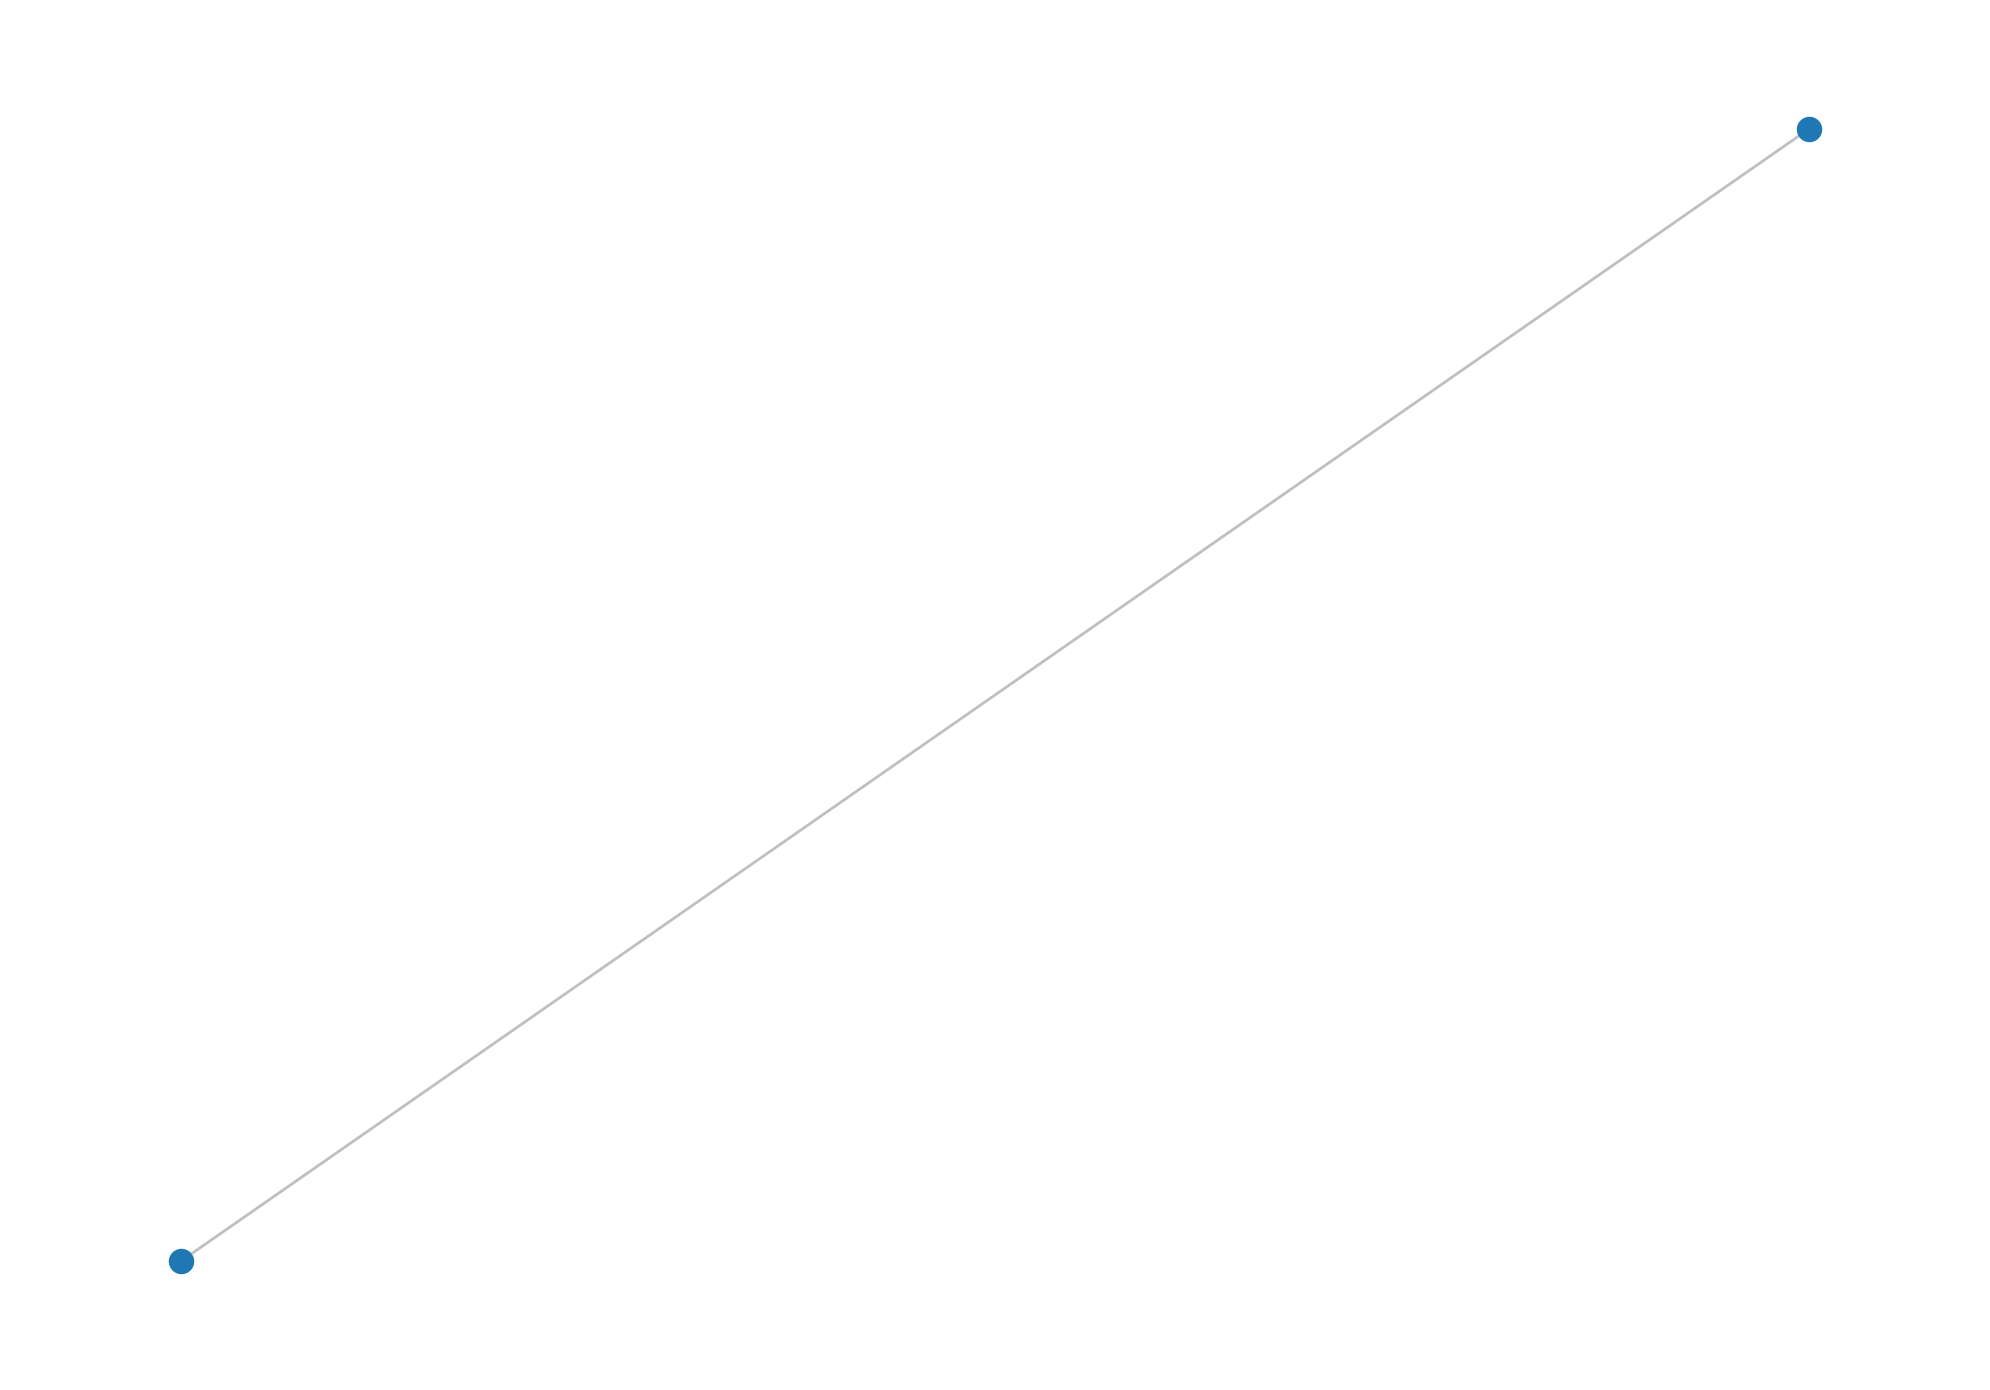

In [112]:
for i in range(3):
  subgraph = island_papers[i][1]
  # set figure size
  plt.figure(figsize=(20,14))
  # determine the positions using spring layout
  pos = nx.random_layout(subgraph)
  nx.draw_networkx_edges(subgraph,pos,edge_color='grey',
      alpha=0.5,width=2)


  # nx.draw(g,pos)
  nx.draw_networkx_nodes(subgraph, pos)
  # set tight layout
  plt.tight_layout()
  # remove axis
  plt.axis('off')

  plt.show()

At the first threshold, the graph is extremely dense. As the threshold increases, the graphs gradually shrink, a notable difference compared to the author graphs described earlier.

## Conclusion:


In conclusion, the use of the island method proved essential for disentangling and visualizing the complex structures within the dataset. By isolating subgraphs based on varying thresholds, it became clear that while the initial network is extremely dense, the meaningful connections—representing common authorship and collaborative efforts—are most prominent at the lowest threshold. This indicates that, despite some clusters of collaboration, the overall network of papers and authors is relatively fragmented. Such insights highlight the importance of employing isolation techniques when interpreting large-scale academic networks, as they not only enhance clarity but also help identify significant patterns in collaboration. Future research could delve deeper into these isolated clusters to better understand the dynamics of academic collaboration and the factors that contribute to the formation of these distinct networks.